In [1]:
import os
os.chdir('..')

In [2]:
import copy
import torch as th
import numpy as np
from statistics import mean
import random
from torch.optim import Adam, SGD
import torch.nn as nn
from torchvision import datasets, transforms
from FLF.model.TorchResNetFactory import TorchResNetFactory

In [3]:
SEED=42
random.seed(SEED)
np.random.seed(SEED)
th.manual_seed(SEED)
th.backends.cudnn.deterministic = True
th.backends.cudnn.benchmark = False

In [4]:
norm = transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))

trfs = [
    transforms.ToTensor(),
    norm,
]

transform = transforms.Compose(trfs)
cifar100_train_ds = datasets.CIFAR10(
            "data/cifar10", download=True, transform=transform,
        )
train_loader = th.utils.data.DataLoader(
    dataset=cifar100_train_ds,
    batch_size=1024,
    pin_memory=True,
)

Files already downloaded and verified


In [5]:
def set_model_grad(opt, model, new_state):
#     opt.zero_grad()
    new_model = copy.deepcopy(model)
    new_model.load_state_dict(new_state)
    with th.no_grad():
        for parameter, new_parameter in zip(
            model.parameters(), new_model.parameters()
        ):
            parameter.grad = (parameter.data - new_parameter.data)
            # because we go to the opposite direction of the gradient
    model_state_dict = model.state_dict()
    new_model_state_dict = new_model.state_dict()
    for k in dict(model.named_parameters()).keys():
        new_model_state_dict[k] = model_state_dict[k]
    model.load_state_dict(new_model_state_dict)
    return model

In [19]:
lr=1e-3
fac = TorchResNetFactory("group", None)
model = fac().cuda()
opt = Adam(model.parameters(), lr=lr)
loss_fn = nn.CrossEntropyLoss()

In [20]:
sd = model.state_dict()

In [21]:
sd['fc.bias']

tensor([-0.0041, -0.0346,  0.0017, -0.0009,  0.0192, -0.0188,  0.0408,  0.0112,
         0.0086, -0.0441, -0.0229,  0.0387,  0.0391,  0.0053, -0.0324, -0.0085,
        -0.0127,  0.0114, -0.0268,  0.0008, -0.0223, -0.0314, -0.0359,  0.0158,
         0.0231,  0.0333, -0.0265,  0.0348, -0.0036, -0.0280, -0.0366, -0.0115,
         0.0406,  0.0277, -0.0097,  0.0112,  0.0190, -0.0055,  0.0405, -0.0416,
         0.0339,  0.0418,  0.0414,  0.0249, -0.0256,  0.0310,  0.0274, -0.0274,
        -0.0052, -0.0088,  0.0214, -0.0366, -0.0254, -0.0183, -0.0401, -0.0379,
        -0.0262,  0.0432,  0.0257, -0.0122, -0.0320,  0.0434,  0.0141,  0.0338,
         0.0382, -0.0056,  0.0200,  0.0055, -0.0179, -0.0090,  0.0388, -0.0248,
        -0.0270, -0.0047, -0.0276, -0.0147, -0.0002,  0.0291, -0.0027,  0.0204,
         0.0187, -0.0279, -0.0176,  0.0352, -0.0355, -0.0188,  0.0234, -0.0025,
        -0.0121,  0.0440, -0.0405, -0.0153,  0.0149, -0.0038,  0.0329,  0.0374,
        -0.0253,  0.0045,  0.0384,  0.01

In [22]:
for curr_epoch in range(0):
    losses = []
    for curr_batch, (data, target) in enumerate(train_loader):
        proxy_model = fac()
        proxy_model.load_state_dict(sd)
        proxy_model.cuda()
#         proxy_model = copy.deepcopy(model).cuda()
        data, target = data.cuda(), target.cuda()
        proxy_opt = SGD(proxy_model.parameters(), lr=1)
        proxy_opt.zero_grad()
        output = proxy_model(data)
        loss = loss_fn(output, target)
        loss.backward()
        proxy_opt.step()
        osd = opt.state_dict()
        opt.zero_grad()
        set_model_grad(opt, model, proxy_model.state_dict())
        opt = Adam(model.parameters(), lr=lr)
        opt.load_state_dict(osd)
#         opt.zero_grad()
#         print(dict(model.named_parameters())['conv1.weight'].grad[0,0])
        opt.step()
        losses.append(loss.item())
        print(loss.item())
        break
        if curr_batch == 2:
            break
    print(mean(losses))

In [23]:
sd['fc.bias']

tensor([-0.0041, -0.0346,  0.0017, -0.0009,  0.0192, -0.0188,  0.0408,  0.0112,
         0.0086, -0.0441, -0.0229,  0.0387,  0.0391,  0.0053, -0.0324, -0.0085,
        -0.0127,  0.0114, -0.0268,  0.0008, -0.0223, -0.0314, -0.0359,  0.0158,
         0.0231,  0.0333, -0.0265,  0.0348, -0.0036, -0.0280, -0.0366, -0.0115,
         0.0406,  0.0277, -0.0097,  0.0112,  0.0190, -0.0055,  0.0405, -0.0416,
         0.0339,  0.0418,  0.0414,  0.0249, -0.0256,  0.0310,  0.0274, -0.0274,
        -0.0052, -0.0088,  0.0214, -0.0366, -0.0254, -0.0183, -0.0401, -0.0379,
        -0.0262,  0.0432,  0.0257, -0.0122, -0.0320,  0.0434,  0.0141,  0.0338,
         0.0382, -0.0056,  0.0200,  0.0055, -0.0179, -0.0090,  0.0388, -0.0248,
        -0.0270, -0.0047, -0.0276, -0.0147, -0.0002,  0.0291, -0.0027,  0.0204,
         0.0187, -0.0279, -0.0176,  0.0352, -0.0355, -0.0188,  0.0234, -0.0025,
        -0.0121,  0.0440, -0.0405, -0.0153,  0.0149, -0.0038,  0.0329,  0.0374,
        -0.0253,  0.0045,  0.0384,  0.01

In [207]:
dict(model.named_parameters())['conv1.weight'].grad#.grad

tensor([[[[-5.1964e-04, -7.5099e-04, -7.7849e-04,  ..., -7.9390e-04,
           -7.8128e-04, -7.0355e-04],
          [-5.7446e-04, -9.3726e-04, -9.4942e-04,  ..., -9.6111e-04,
           -9.2909e-04, -8.7214e-04],
          [-4.7459e-04, -8.2957e-04, -8.3418e-04,  ..., -9.0189e-04,
           -9.0383e-04, -8.6621e-04],
          ...,
          [-2.6784e-04, -5.3352e-04, -5.6124e-04,  ..., -5.8555e-04,
           -6.4203e-04, -7.1487e-04],
          [-2.7991e-04, -5.6035e-04, -5.6879e-04,  ..., -6.2846e-04,
           -6.9198e-04, -7.4713e-04],
          [-4.4342e-04, -7.4163e-04, -7.4319e-04,  ..., -8.0719e-04,
           -8.5181e-04, -8.4979e-04]],

         [[-4.2628e-04, -5.9990e-04, -6.2329e-04,  ..., -6.1104e-04,
           -5.9597e-04, -5.2226e-04],
          [-4.6093e-04, -7.0799e-04, -7.0910e-04,  ..., -7.0908e-04,
           -6.6851e-04, -6.1252e-04],
          [-3.7265e-04, -6.0564e-04, -6.0621e-04,  ..., -6.6478e-04,
           -6.4626e-04, -6.0029e-04],
          ...,
     

In [118]:
def set_model_grad(opt, model, new_state):
#     opt.zero_grad()
    new_model = copy.deepcopy(model)
    new_model.load_state_dict(new_state)
    with th.no_grad():
        for parameter, new_parameter in zip(
            model.parameters(), new_model.parameters()
        ):
            parameter.grad = (parameter.data - new_parameter.data) / lr
            # because we go to the opposite direction of the gradient
#     model_state_dict = model.state_dict()
#     new_model_state_dict = new_model.state_dict()
#     for k in dict(model.named_parameters()).keys():
#         new_model_state_dict[k] = model_state_dict[k]
#     model.load_state_dict(new_model_state_dict)
#     return model

In [ ]:
<<<<<<< local
for curr_epoch in range(10):
=======
for curr_epoch in range(1):
>>>>>>> remote
    losses = []
    for curr_batch, (data, target) in enumerate(train_loader):
        data, target = data.cuda(), target.cuda()
        opt.zero_grad()
        output = model(data)
        loss = loss_fn(output, target)
        loss.backward()
        opt.step()
        losses.append(loss.item())
<<<<<<< local
    print(mean(losses))
#         if curr_batch == 25:
#             break
=======
        print(loss.item())
        if curr_batch == 10:
            break
    print(mean(losses))
>>>>>>> remote

<<<<<<< local


2.903967541091296
2.229589214130324
2.096755329443484
1.9915922928829581
1.9060080756946487
1.837339082542731
1.778830100078972
1.7282127628521042
1.6852372884750366
1.6488727014891955


5.007709980010986
2.933006525039673
2.8500783443450928
2.803913116455078
2.575599193572998
2.4126853942871094
2.307126998901367
2.389631986618042
2.3849844932556152
2.3134987354278564
2.283076763153076
2.7510283210060815


>>>>>>> remote


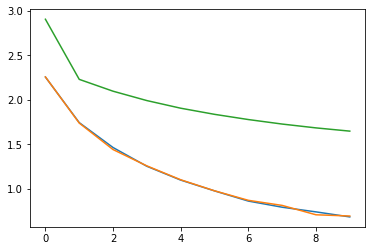

In [60]:
import matplotlib.pyplot as plt
my = [2.25688911457451, 1.7395180926030995, 1.4419828556021865, 1.2589620351791382, 1.1033586433955602, 0.9795068198320817, 0.8727953081228295, 0.8156435428833475, 0.7105233778758925, 0.6967345451822087]
org = [2.255778692206558, 1.7442619922209759, 1.4649563127634477, 1.254581709297336, 1.0997444026324215, 0.9786830009246359, 0.8643052176553376, 0.7954211551315931, 0.7430968661697543, 0.6865700763099047]
sgd = [2.903967541091296, 2.229589214130324, 2.096755329443484, 1.9915922928829581, 1.9060080756946487, 1.837339082542731, 1.778830100078972, 1.7282127628521042, 1.6852372884750366, 1.6488727014891955]
plt.plot(org)
plt.plot(my)
plt.plot(sgd)
plt.show()

In [47]:
<<<<<<< REMOTE CELL DELETED >>>>>>>
for curr_epoch in range(10):
    losses = []
    for curr_batch, (data, target) in enumerate(train_loader):
        proxy_model = copy.deepcopy(model).cuda()
        data, target = data.cuda(), target.cuda()
        proxy_opt = SGD(proxy_model.parameters(), lr=lr)
        proxy_opt.zero_grad()
        output = proxy_model(data)
        loss = loss_fn(output, target)
        loss.backward()
        proxy_opt.step()
        opt.zero_grad()
        set_model_grad(opt, model, proxy_model.state_dict())
        opt.step()
        losses.append(loss.item())
    print(mean(losses))
#         if curr_batch == 25:
#             break

2.25688911457451
1.7395180926030995
1.4419828556021865
1.2589620351791382
1.1033586433955602
0.9795068198320817
0.8727953081228295
0.8156435428833475
0.7105233778758925
0.6967345451822087


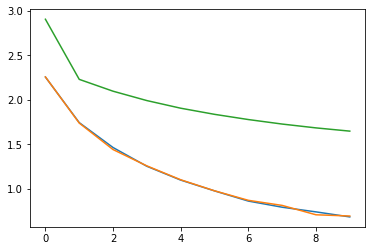

In [60]:
import matplotlib.pyplot as plt
my = [2.25688911457451, 1.7395180926030995, 1.4419828556021865, 1.2589620351791382, 1.1033586433955602, 0.9795068198320817, 0.8727953081228295, 0.8156435428833475, 0.7105233778758925, 0.6967345451822087]
org = [2.255778692206558, 1.7442619922209759, 1.4649563127634477, 1.254581709297336, 1.0997444026324215, 0.9786830009246359, 0.8643052176553376, 0.7954211551315931, 0.7430968661697543, 0.6865700763099047]
sgd = [2.903967541091296, 2.229589214130324, 2.096755329443484, 1.9915922928829581, 1.9060080756946487, 1.837339082542731, 1.778830100078972, 1.7282127628521042, 1.6852372884750366, 1.6488727014891955]
plt.plot(org)
plt.plot(my)
plt.plot(sgd)
plt.show()

In [64]:
# model.state_dict()

In [65]:
# model = set_model_grad(opt, model, TorchResNetFactory("group", None)().state_dict())

In [66]:
# model.state_dict()

In [67]:
next(iter(model.parameters())).grad[:5, :5]

tensor([[[[-2.9913e-03, -2.2625e-03, -2.0705e-03,  9.1495e-05, -2.1973e-04,
           -2.4900e-03, -6.5309e-03],
          [-3.8049e-03, -2.0920e-03, -2.8431e-03, -2.2389e-03, -2.9731e-03,
           -6.0943e-03, -1.0834e-02],
          [-7.6445e-03, -4.1388e-03, -9.3102e-04, -3.2318e-03, -8.6277e-03,
           -8.5048e-03, -9.7686e-03],
          [-4.2320e-03, -2.2804e-03,  5.2502e-04, -1.7948e-03, -5.1756e-03,
           -4.5959e-03, -7.2187e-03],
          [-1.2224e-03, -4.5456e-04, -7.8907e-05, -3.1534e-03, -6.5503e-03,
           -7.0068e-03, -6.7319e-03],
          [ 1.7490e-03,  2.3119e-03, -1.2318e-03, -2.2847e-03, -6.1482e-03,
           -5.5855e-03, -2.8146e-03],
          [ 2.9871e-03,  2.1173e-03, -1.0877e-03,  1.4219e-03, -1.0624e-03,
           -6.2058e-03, -4.2820e-03]],

         [[ 2.4421e-03,  1.0626e-03,  9.1221e-05,  3.6967e-03,  4.9774e-03,
            3.1004e-03, -2.0609e-03],
          [ 2.0699e-03,  1.9007e-03, -1.7900e-04,  1.4305e-03,  2.0817e-03,
          

In [68]:
# model = TorchResNetFactory("group", None)()
new_state = model.state_dict()
model = prev_model
new_model = copy.deepcopy(model)
new_model.load_state_dict(new_state)
with th.no_grad():
    for parameter, new_parameter in zip(
        model.parameters(), new_model.parameters()
    ):
        parameter.grad = (parameter.data - new_parameter.data) / 1e-3
        # because we go to the opposite direction of the gradient
# model_state_dict = model.state_dict()
# new_model_state_dict = new_model.state_dict()
# for k in dict(model.named_parameters()).keys():
#     new_model_state_dict[k] = model_state_dict[k]
# model.load_state_dict(new_model_state_dict)

In [69]:
next(iter(model.parameters())).grad[:5, :5]

tensor([[[[-2.9914e-03, -2.2631e-03, -2.0713e-03,  9.1270e-05, -2.1979e-04,
           -2.4885e-03, -6.5304e-03],
          [-3.8054e-03, -2.0936e-03, -2.8431e-03, -2.2389e-03, -2.9728e-03,
           -6.0946e-03, -1.0833e-02],
          [-7.6443e-03, -4.1388e-03, -9.3086e-04, -3.2317e-03, -8.6278e-03,
           -8.5048e-03, -9.7677e-03],
          [-4.2319e-03, -2.2799e-03,  5.2527e-04, -1.7956e-03, -5.1744e-03,
           -4.5951e-03, -7.2187e-03],
          [-1.2224e-03, -4.5449e-04, -7.9162e-05, -3.1535e-03, -6.5509e-03,
           -7.0073e-03, -6.7316e-03],
          [ 1.7490e-03,  2.3134e-03, -1.2317e-03, -2.2845e-03, -6.1467e-03,
           -5.5842e-03, -2.8146e-03],
          [ 2.9872e-03,  2.1160e-03, -1.0878e-03,  1.4231e-03, -1.0626e-03,
           -6.2063e-03, -4.2822e-03]],

         [[ 2.4419e-03,  1.0617e-03,  9.1270e-05,  3.6964e-03,  4.9775e-03,
            3.1004e-03, -2.0609e-03],
          [ 2.0699e-03,  1.8999e-03, -1.7905e-04,  1.4305e-03,  2.0824e-03,
          